# Image Retrieval with Fine-Tuned OpenCLIP Model

In [1]:
# Import packages
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.distributed as dist
from PIL import Image
import pandas as pd
import os
import numpy as np
import math
import open_clip
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt
import textwrap

## Load annotations (Tropy export)

In [4]:
## Import labels from Tropy export file (JSON-LD)

# Load JSON data into a Pandas DataFrame
with open('ONiT Annotations D16-L18-2024-09-05.json') as f:
    data = json.load(f)

df = pd.json_normalize(data['@graph'])

# Expand the "tag" column into separate rows
df_expanded = df.explode('tag')
df_expanded = df_expanded[['title', 'list', 'tag']]

# Rename filenames to add .jpg at the end
df_expanded['title'] = df_expanded['title'].astype(str) + '.jpg'

# Group by 'title' and aggregate 'list' by keeping the first, 'tag' by concatenation
df_merg = df_expanded.groupby('title').agg({
    'list': 'first',   # Keep the first value in column 'value'
    'tag': lambda x: '|'.join(map(str, x.dropna()))   # Convert values to strings, drop NaNs, and concatenate
}).reset_index()

merged_df = df_merg[['title', 'list', 'tag']].copy().rename(columns = {'title':'filename', 'list':'corpus', 'tag':'label'})

## Format annotations
filtered_df = merged_df.copy()

'''strip leading and trailing space'''
#filtered_df['label'] = filtered_df['label'].astype('string').str.replace(" ","")

'''strip initial and final [] ''' 
filtered_df['corpus'] = filtered_df['corpus'].astype('string').str.replace("[", "", regex=False)
filtered_df['corpus'] = filtered_df['corpus'].str.replace("]", "", regex=False)

'''strip initial and final [' '] ''' 
filtered_df['label'] = filtered_df['label'].str.replace("'", "")
filtered_df['corpus'] = filtered_df['corpus'].str.replace("'", "")

#filtered_df

## Merge annotations with full extracted images dataset

In [3]:
# ONiT data paths
onit_full_csv = 'ONiT_data/ONiT_extracted-images_singleEditions_2024-07.csv' ## extracted images from single editions

onit_data = pd.read_csv(onit_full_csv, sep=',', na_filter=False)

onit_data = onit_data[['filename', 'barcode', 'iiif', 'lang_year']]

#Annotations
annotations = filtered_df[['filename', 'label']]
# Fill empty cells in the 'label' column with 'N/A'
annotations['label_filled'] = annotations['label'].fillna('N/A')
annotations['label_filled'] = annotations['label_filled'].apply(lambda x: tuple(x.split('|')))

# Add annotations to onit_data dataframe
onit_full_annotated = onit_data.merge(annotations[['filename', 'label_filled']], on='filename', how='left')
onit_full_annotated = onit_full_annotated.fillna('N/A') ## fill empy cells (i.e. with no label) with 'N/A'
#onit_full_annotated = onit_full_annotated.dropna().reset_index(drop=True) ## filter rows with no label (i.e. not part of curated dataset)

onit_full_annotated

,filename,barcode,iiif,lang_year,label_filled
0,Z156265702_00002_page2_01.jpg,Z156265702,https://iiif.onb.ac.at/images/ABO/Z156265702/0...,D16,N/A
1,Z156577207_00001_page1_01.jpg,Z156577207,https://iiif.onb.ac.at/images/ABO/Z156577207/0...,D16,N/A
2,Z156577207_00002_page2_01.jpg,Z156577207,https://iiif.onb.ac.at/images/ABO/Z156577207/0...,D16,N/A
3,Z156577207_00009_page9_01.jpg,Z156577207,https://iiif.onb.ac.at/images/ABO/Z156577207/0...,D16,"(plants; vegetation, 25G*, animals, 25F*, bird..."
4,Z156577207_00012_page12_01.jpg,Z156577207,https://iiif.onb.ac.at/images/ABO/Z156577207/0...,D16,N/A
...,...,...,...,...,...
22294,Z258752304_00002_page2_01.jpg,Z258752304,https://iiif.onb.ac.at/images/ABO/Z258752304/0...,L19,N/A
22295,Z258752304_00002_page2_02.jpg,Z258752304,https://iiif.onb.ac.at/images/ABO/Z258752304/0...,L19,N/A
22296,Z258752304_00003_page3_01.jpg,Z258752304,https://iiif.onb.ac.at/images/ABO/Z258752304/0...,L19,N/A
22297,Z258752304_00590_page590_01.jpg,Z258752304,https://iiif.onb.ac.at/images/ABO/Z258752304/0...,L19,N/A


## Load Data

In [5]:
# ONiT data path
onit_data_dir = 'ONiT_data/'

# Load ONiT image data
onit_filenames = []
onit_paths = []
lang_year = []
labels = []
labels_short = []

# Load image paths
for index, row in onit_full_annotated.iterrows():
    onit_filename = row["filename"]

    if onit_filename[9] == "_":
        barcode = onit_filename[:9]        
    else:
        barcode = onit_filename[:10]
        
    onit_tag = row["lang_year"]
    onit_path = os.path.join(onit_data_dir, onit_tag, barcode, onit_filename)
    label = row["label_filled"]
    #print(type(label))
    onit_paths.append(onit_path)
    onit_filenames.append(onit_filename)
    lang_year.append(onit_tag)
    labels.append(label)
    labels_short.append(label[0])

print(len(onit_filenames))

22299


## Load image preprocessing parameters, model classes, and data loader

In [6]:
# Import image preprocessing packages
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

# Define custom image preprocessing parameters
BATCH_SIZE = 128
IMAGE_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
train_val_split_ratio = 0.8 # 80/20 ratio for training/validation data

# Define pad function (add black borders to keep aspect ratio)
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return F.pad(image, padding, 0, 'constant')

# Define custom preprocess function
preprocess = transforms.Compose([
    SquarePad(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

In [7]:
# FineTuned Model class (needed to load the model)
class FTModel(nn.Module):
    def __init__(self, model):
        super(FTModel, self).__init__()
        self.model = model

    def forward(self, images, captions):
        image_outputs = self.model.encode_image(images)
        caption_outputs = self.model.encode_text(captions)

        # print('Image outputs shape: ', image_outputs.shape)
        # print('Caption outputs shape: ', caption_outputs.shape)
        return image_outputs, caption_outputs

# Dataset class & Data Loader
class OnitFull(Dataset):
    def __init__(self, onit_paths, transform=None):
        self.onit_paths = onit_paths
        self.preprocess = preprocess

    def __len__(self):
        return len(self.onit_paths)

    def __getitem__(self, idx):
        image_path = self.onit_paths[idx]
        try:
            with open(image_path, 'rb') as f:
                image = Image.open(f).convert("RGB")
                image_prep = preprocess(image)
                return image_prep
        except FileNotFoundError:
            print(f"Warning: Image file {image_path} not found. Skipping...")
            pass

# Data Loader
onit_full_dataset = OnitFull(onit_paths)
onitdata_loader = DataLoader(onit_full_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Load model and get features

In [8]:
# Load fine-tuned model
SAVE_MODEL = 'model/' # Path of saved fine-tuned model
device = 'cpu'

finetuned_checkpoint = os.path.join(SAVE_MODEL, "ViT-B-32_wise_ft_full_alpha=0.500.pt")
model = torch.load(finetuned_checkpoint, map_location=torch.device(device))

# Load pre-trained model
#model, _, _ = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion400m_e31', device=device)

In [8]:
# Get features of ONiT dataset with loaded image encoder of fine-tuned/pre-trained model

# Get Features function
def get_features(onit_full_dataset):
    image_features = []

    with torch.no_grad():
        for image_prep in tqdm(onitdata_loader):
            #print('Images: ', image_prep.shape)
            imfeat = model.model.encode_image(image_prep.to(device)) ## Fine-tuned model
            #imfeat = model.encode_image(image_prep.to(device)) ## Pre-trained model
            
            image_features.append(imfeat)

    return torch.cat(image_features).cpu().numpy()

# Calculate image features
image_features = get_features(onit_full_dataset)

  0%|          | 0/69 [00:00<?, ?it/s]

In [9]:
#np.save("onit_singleEditions_image_embeddings_resblocks10-11_finetune.npy", image_features)

## Image retrieval with natural language prompt

In [9]:
# Import text preprocessing packages
from open_clip import tokenizer

tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [10]:
# Load image features
## embeddings of all extracted images
allExtracted = "CLIP-finetune-DH2023paper_eval_NEW/onit_allExtracted_singleEditions_image_embeddings_resblocks10-11_finetune.npy"
## embeddings of curated images only
curatedOnly = "CLIP-finetune-DH2023paper_eval_NEW/onit_curatedOnly-8720_singleEditions_image_embeddings_resblocks10-11_finetune.npy"

loaded_image_features = np.load(allExtracted)
image_embeddings = torch.tensor(loaded_image_features, device=device)

print(len(image_embeddings))
print(len(onit_paths))

# Image similarity
from sklearn.metrics.pairwise import cosine_similarity

22299
22299


In [11]:
# Text prompt describing the type of images you are looking for
### Four main classes ###
#text_prompt = "An image of an animal" ## check label 'animals,25F'
#text_prompt = "An image of a plant" ## 'plants;vegetation,25G'
#text_prompt = "An image of a landscape" ## 'landscapes,25H'
#text_prompt = "An image of a map" ## 'maps;atlases,25A'

### Most recurring animal classes ###
#text_prompt = "An image of a horse" ## check label 'horsesandkindredanimals,46C1314' >1,000
#text_prompt = "An image of a bird" ## 'birds,25F3' >900

### Other examples <350 occurrences ###
#text_prompt = "An image of a fabulous animal" ## 'fabulousanimals,25FF'
#text_prompt = "An image of a camel" ## 'camel,25F24'
text_prompt = "An image of a dog" ## 'dog,34B11'
#text_prompt = "An image of a cat" ## 'cat,34B12'
#text_prompt = "An image of a giraffe" ## 'hoofed animals (GIRAFFE), 25F24'

### Retrieval based on cosine similarity ###
# Encode the text prompt to get the text embedding
with torch.no_grad():
    text_embedding = model.model.encode_text(tokenizer(text_prompt).to(device)) #for fine-tuned model
    #text_embedding = model.encode_text(tokenizer(text_prompt).to(device)) #for original CLIP model

print(text_embedding.shape)
print(image_embeddings.shape)

# Compute the cosine similarity between the text prompt and all images
similarities = cosine_similarity(text_embedding.cpu(), image_embeddings.cpu())
similarities_tensor = torch.tensor(similarities[0], device=device)

# Sort the images based on similarity (descending order)
similar_images_indices = torch.argsort(similarities_tensor, descending=True)
similar_ranks = list(enumerate(similar_images_indices.tolist()))
#print(similar_ranks)

torch.Size([1, 512])
torch.Size([22299, 512])


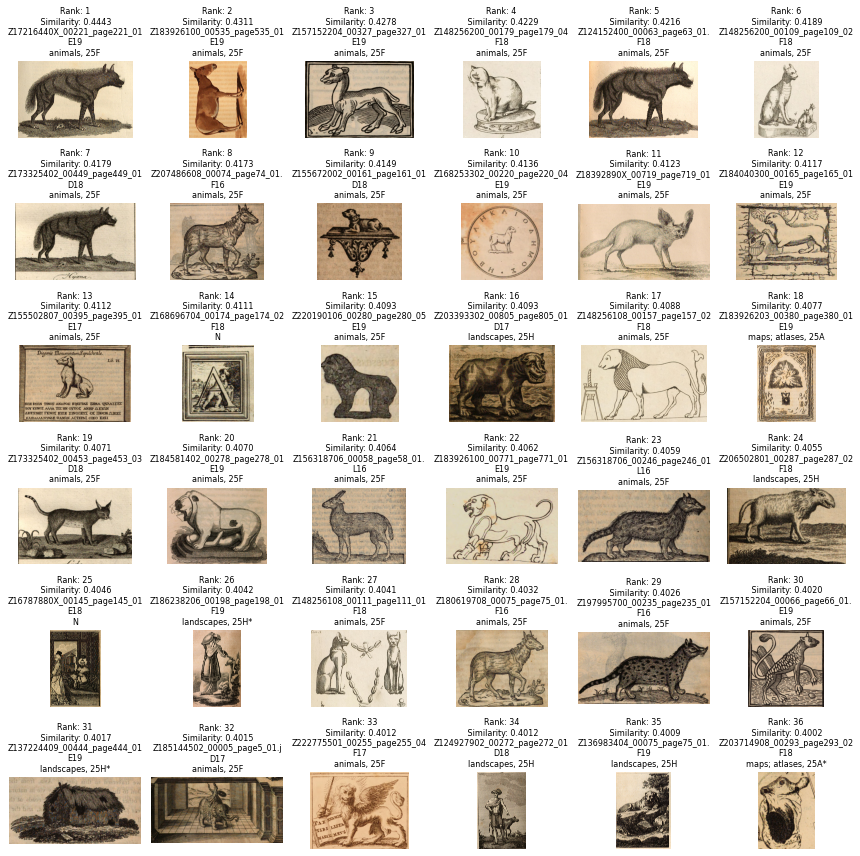

In [12]:
### Preview top ranked images (slow) ###
# Load the images for visualization
top_n = 36  # Show the top 36 similar images
fig, axes = plt.subplots(6, 6, figsize=(12, 12))

for i in range(top_n):
    #print(onit_paths[i])
    index = similar_images_indices[i].item()
    image_path = onit_paths[index]
    image = Image.open(image_path)
    
    # Plot the image
    axes[i // 6, i % 6].imshow(image)
    axes[i // 6, i % 6].axis("off")
    
    # Set the title with two lines
    axes[i // 6, i % 6].set_title(f"Rank: {i + 1}\n Similarity: {similarities_tensor[similar_images_indices[i]]:.4f}\n{(onit_filenames[index])[:27]}\n{(lang_year[index])}\n{labels_short[index]}", fontsize=8)

plt.tight_layout()
plt.show()

# Evaluation of Fine-Tuned Model

In [13]:
# Convert torch tensor to a Python list
similar_images_indices_list = similar_images_indices.cpu().numpy().tolist()

# Initialize counters for absolute numbers
total_tuples = 0
indices_TP = []
similarities_scores_TP = []
indices_FP = []
similarities_scores_FP = []

### String of searched animal (to compare with annotated images) ###
#string = 'animals, 25F' ## 
#string = 'plants; vegetation, 25G'
#string = 'landscapes, 25H'
#string = 'maps; atlases, 25A'

#string = 'horses and kindred animals, 46C1314'
#string = 'birds, 25F3'
#string = 'fabulous animals, 25FF'
#string = 'camel, 25F24'
string = 'dog, 34B11'
#string = 'cat, 34B12'
#string = 'hoofed animals (GIRAFFE), 25F24'

# Iterate over the first k indices
k = 1000
for index in similar_images_indices_list[:k]: # Top-K indices sorted by descending similarity scores
    # Check if the element at the specified index is iterable
    if hasattr(labels[index], '__iter__'):
        total_tuples += 1
        # Check if the tuple contains the string = True Positives (TP)
        if any(string in item for item in labels[index]):
            # Append index TP
            indices_TP.append(index)
            # Append similarity score TP
            similarities_scores_TP.append(similarities_tensor[index])
        else:
            # Append index FP
            indices_FP.append(index)
            # Append similarity score TP
            similarities_scores_FP.append(similarities_tensor[index])

# Calculate percentages
percentage_with_string = (len(indices_TP) / total_tuples) * 100 if total_tuples != 0 else 0

# Print summary
print(f"Total tuples checked: {total_tuples}")
print(f"True Positives {string}: {len(indices_TP)} (=TP)")
print(f"False Positives {string}: {len(indices_FP)} (=FP)")
print(f"Percentage TP {string}: {percentage_with_string:.2f}%")

Total tuples checked: 1000
True Positives dog, 34B11: 40 (=TP)
False Positives dog, 34B11: 960 (=FP)
Percentage TP dog, 34B11: 4.00%


## Calculate metrics

In [14]:
# Initialize lists to store indices and similarity scores of all images with the selected tag
indices_labelled_animals = []
similarities_scores_animals = []

# Iterate over all indices
for index in similar_images_indices_list:
    # Check if the element at the specified index is iterable
    if hasattr(labels[index], '__iter__'):
        # Check if the tag 'animals' is present in any label
        if any(string in item for item in labels[index]):
            # Append the similarity score corresponding to the index
            similarities_scores_animals.append(similarities_tensor[index])
            # Append the index to the list of indices labeled with 'animals'
            indices_labelled_animals.append(index)

# False Negatives (FN)
indices_FN = [index for index in indices_labelled_animals if index not in indices_TP]

# True Negatives (TN)
TN = len(similar_images_indices_list)-len(indices_labelled_animals)-len(indices_FP)

# Recall at K
recall_at_k = len(indices_TP)/(len(indices_TP)+len(indices_FN)) ### Recall@K = TP/(TP+FN)

# Precision at K
precision_at_k = len(indices_TP)/(len(indices_TP)+len(indices_FP)) ### Precision@K = TP/(TP+FP)

# Fallout at K
fallout_at_k = len(indices_FP)/(len(indices_FP)+TN) ### Fallout@K = FP / (FP + TN)

print(f"Total occurrences of {string}: {len(indices_labelled_animals)}")
print(f"False Negatives {string}: {len(indices_FN)}")
print(f"Recall@{k}: {recall_at_k}")
print(f"Precision@{k}: {precision_at_k}")
print(f"Fallout@{k}: {fallout_at_k}")
print(f"TP: {len(indices_TP)}, FP: {len(indices_FP)}, TN: {TN}")

Total occurrences of dog, 34B11: 274
False Negatives dog, 34B11: 234
Recall@1000: 0.145985401459854
Precision@1000: 0.04
Fallout@1000: 0.04358683314415437
TP: 40, FP: 960, TN: 21065
----------------------


In [15]:
## Calculate R-precision

# Iterate over the first R indices
R = len(indices_labelled_animals)

indices_rel = []

for index in similar_images_indices_list[:R]: # Top-K indices sorted by descending similarity scores
    # Check if the element at the specified index is iterable
    if hasattr(labels[index], '__iter__'):
        total_tuples += 1
        # Check if the tuple contains the string = True Positives (TP)
        if any(string in item for item in labels[index]):
            # Append index TP
            indices_rel.append(index)
            # Append similarity score TP
            similarities_scores_TP.append(similarities_tensor[index])


R_precision = len(indices_rel)/R ### R-precision = relevant_in_top_R / all_relevant_documents

print(f"R-precision at {R}: {R_precision}")

R-precision at 274: 0.051094890510948905


## Inspect True Positives, False Positives, etc.

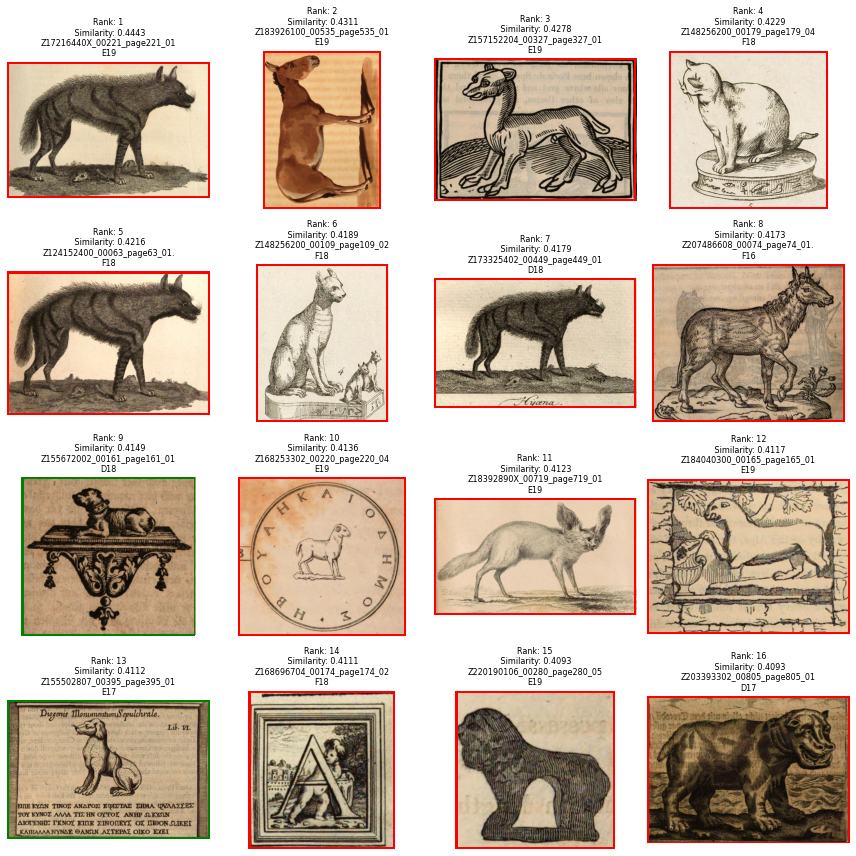

In [16]:
# Visualise True Positive & False Positive images

import matplotlib.patches as patches

top_n = 16  # Show the top 36 similar images
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i in range(top_n):
    index = similar_images_indices[i].item()
    image_path = onit_paths[index]
    image = Image.open(image_path)
    
    # Plot the image
    axes[i // 4, i % 4].imshow(image)
    axes[i // 4, i % 4].axis("off")
    
    # Highlight the images if index is in indices_TP
    for y in indices_TP:
        if index == y:
            # Create a rectangle patch with a red border
            rect = patches.Rectangle((0, 0), image.size[0], image.size[1], linewidth=4, edgecolor='green', facecolor='none')
            # Add the rectangle to the axes
            axes[i // 4, i % 4].add_patch(rect)
            
    # Highlight the images if index is in indices_FP
    for z in indices_FP:
        if index == z:
            # Create a rectangle patch with a red border
            rect = patches.Rectangle((0, 0), image.size[0], image.size[1], linewidth=4, edgecolor='red', facecolor='none')
            # Add the rectangle to the axes
            axes[i // 4, i % 4].add_patch(rect)

    # Set the title with two lines
    axes[i // 4, i % 4].set_title(f"Rank: {i + 1}\n Similarity: {similarities_tensor[similar_images_indices[i]]:.4f}\n{(onit_filenames[index])[:27]}\n{(lang_year[index])}", fontsize=8)

plt.tight_layout()
plt.show()

Visualisation of highest ranked TP of dog, 34B11


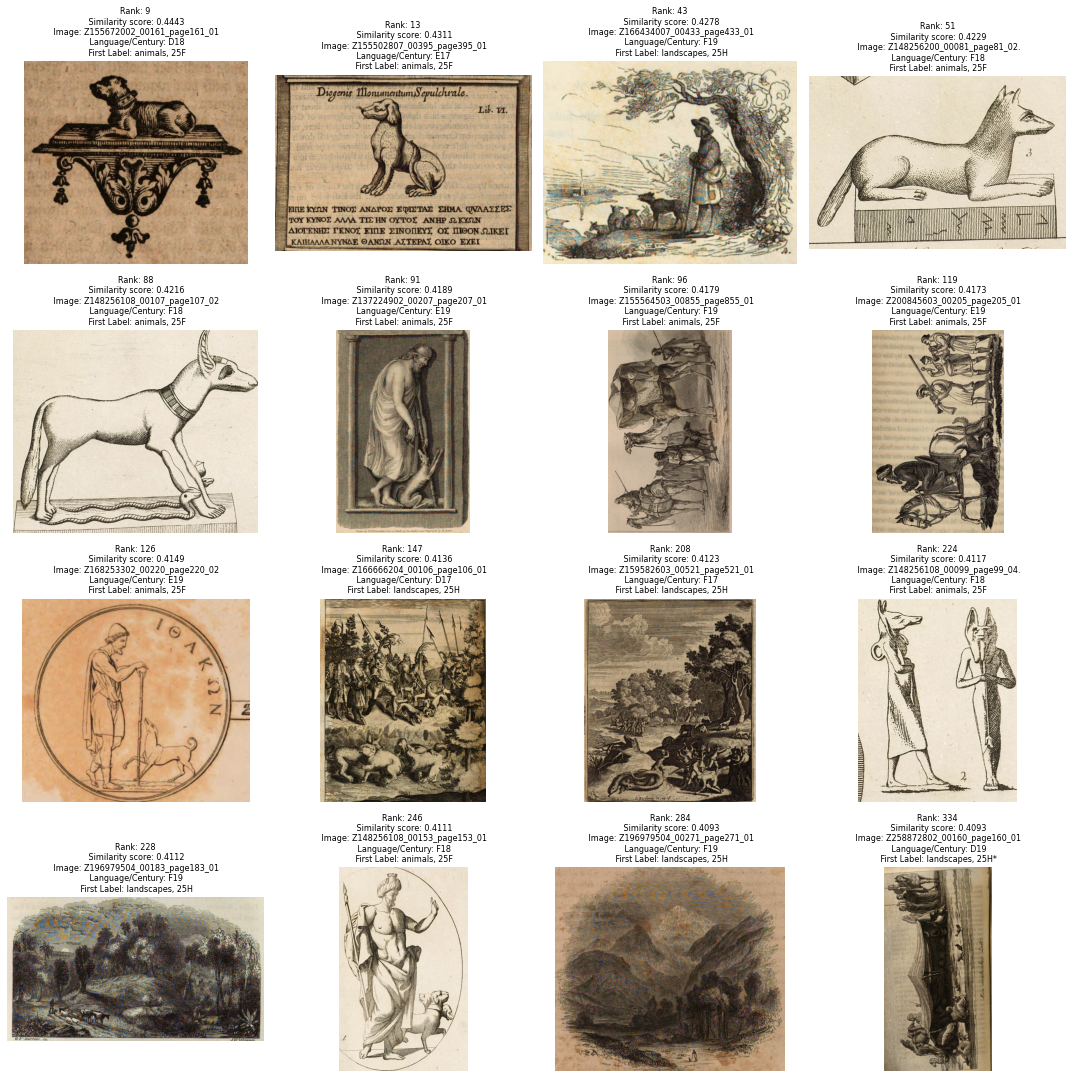

In [17]:
# Visualise Ground Truth

import matplotlib.pyplot as plt
from PIL import Image

#indices = indices_labelled_animals[:16] # Full GT
indices = indices_TP[:16] # highest ranked TP
#indices = indices_TP[-16:] # lowest ranked TP
#indices = indices_FP[:16] # highest ranked FP
#indices = indices_FP[-16:] # lowest ranked FP
#indices = indices_FN[:16] # highest ranked FN
#indices = indices_FN[-16:] # lowest ranked FN

# Number of images to display (assuming you want to display all)
num_images = len(indices)

# Create a figure and axes with a grid to fit the images
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

# Flatten the axes array if it's multidimensional
axes = axes.flatten()

# Loop over indices and display each image
for i, img_idx in enumerate(indices):
    index = img_idx
    image_path = onit_paths[index]
    image = Image.open(image_path)
    for r, y in similar_ranks:
        #print(r, y)
        if y == index:
            rank = r + 1
    
    # Display image on the corresponding axis
    axes[i].imshow(image)
    axes[i].axis("off")  # Turn off axes
    
    # Optionally, add a title or label
    axes[i].set_title(f"Rank: {rank}\n Similarity score: {similarities_tensor[similar_images_indices[i]]:.4f}\n Image: {(onit_filenames[index])[:27]}\n Language/Century: {(lang_year[index])}\n First Label: {labels_short[index]}", fontsize=8)

# Hide any unused subplots
for ax in axes[len(indices_labelled_animals):]:
    ax.axis("off")

print(f"Visualisation of highest ranked TP of {string}")
plt.tight_layout()
plt.show()